# Post-Antibiotic Gut Mucosal Microbiome Reconstitution | Comparison between PCA and TCAM

## Setup

Let’s begin by importing the modules we’ll need.

In [1]:
import pandas as pd
import pathlib as pl
import scipy
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import set_matplotlib_formats, display_markdown
from matplotlib_venn import venn2 ,venn2_circles

import random
from multiprocessing import Pool
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from itertools import combinations

from scipy.fftpack import dct, idct

sns.set_style('ticks')


import sys 
sys.path.append('/home/labs/elinav/uria/mprod_package/')
from mprod.dimensionality_reduction import TCAM
from mprod import table2tensor
from sklearn.preprocessing import StandardScaler
from importlib import reload

import os
os.environ["PATH"] += os.pathsep + '/apps/RH7U2/gnu/texlive/2016/bin/x86_64-linux/'


%matplotlib inline

Ploting configurations

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['font.sans-serif'] = ['Arial']

BU = 2.23

### Data transformation functions

In [3]:
def logfolds_from_baseline_mean(subject_df):
    xcp = subject_df.copy()
    phase_idx = xcp.index.get_level_values('Phase')
    
    xcp = xcp / xcp.loc[phase_idx == 'BAS'].mean()
    xcp = np.log2(xcp)
    return xcp


def logfolds_consecutive(subject_df):
    xcp = subject_df.copy()
    phase_idx = xcp.index.get_level_values('Phase')
    
    xcp = xcp / xcp.loc[phase_idx == 'BAS'].mean()
    xcp.loc[phase_idx == 'INT'] = xcp.loc[phase_idx == 'INT'] / xcp.loc[phase_idx == 'ABX'].mean()
    return np.log2(xcp)




def get_truncated_factors(transformer, criterion = 'n_factors', threshold = -1):
    assert criterion in ['n_factors', 'min_total_var','min_var','gap']
    
    if criterion == 'min_total_var':
        n_factors = np.argmax(transformer.explained_variance_ratio_.cumsum() > threshold) + 1
    elif criterion == 'min_var':
        n_factors = np.argmin(transformer.explained_variance_ratio_ > threshold)
    elif criterion == 'gap':
        n_factors = np.argmin((-np.diff(transformer.explained_variance_ratio_)) > threshold)
    else:
        n_factors = transformer.explained_variance_ratio_.size if threshold == -1 else threshold
    
    n_factors = max(n_factors, 1)
    return n_factors

def prune_factors(transformed_data, row_factors, transformer, criterion = 'n_factors', threshold = -1 ):
    mwt_aov = transformed_data.copy()
    mwt_aov.columns = np.arange(0,mwt_aov.columns.size)
    
    def apply_f(x):
        return pd.Series(scipy.stats.f_oneway(*[x.loc[v] for k,v in row_factors.items()])
                         , index = ['F', 'P(>F)'])
    
    n_factors = get_truncated_factors(transformer, criterion, threshold )
    
    fres = (mwt_aov.iloc[:,:n_factors] ).apply(apply_f).T.sort_values('P(>F)')
    fres['q'] = multipletests(fres['P(>F)'].values, method = 'fdr_bh')[1]
    return fres.sort_values('q')


### PERMANOVA utils

In [4]:

def pairwise_melt_meta(meta, data):
    _dm = pairwise_distances(data.loc[meta['SampleID']])
    for i in range(_dm.shape[0]):
        _dm[i,i:] = None
    _dm_df = pd.DataFrame(_dm, index = meta['SampleID'].rename('sample1'), columns=meta['SampleID'].rename('sample2'))

    _dm_melt = pd.melt(_dm_df.reset_index(), id_vars=['sample1'], value_name='d').dropna()

    metacols = ['rGroup','Participant', 'SampleID']
    _dm_melt2 = meta.loc[:, metacols].merge(_dm_melt, right_on = 'sample2', left_on = 'SampleID', how = 'right').drop('SampleID', axis=1)
    _dm_melt_meta = meta.loc[:, metacols].merge(_dm_melt2, right_on = 'sample1', left_on= 'SampleID', how = 'right', suffixes = ("1","2")).drop('SampleID', axis=1)
    return _dm_melt_meta

def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)


def ss_total(data):
    return (data['d']**2).sum()

def ss_within(data):
    if 'rGroup11' in data.columns:
        # Group11 Group22 are the permuted labels of samples in Group1, Group2 resp'
        return data.query('rGroup11 == rGroup22').groupby('rGroup11')['d'].apply(lambda x: (x**2).sum()).sum()
    else:
        return data.query('rGroup1 == rGroup2').groupby('rGroup1')['d'].apply(lambda x: (x**2).sum()).sum()

def ss_between(data, ss_t):
    return ss_t - ss_within(data)

def Fstat(data, ss_t = None, N = None):
    # p = 2 as there are always 2 groups in our cases
    if N is None:
        N = len(set(data['sample1'].tolist() + data['sample2'].tolist()))
    if ss_t is None:
        ss_t = ss_total(data)
    ss_w = ss_within(data)
    ss_b = ss_t - ss_w
    return ss_b / (ss_w / (N - 2))


def gen_rperm(meta, r):
    _mice_map = meta.loc[:, ['Participant', 'rGroup']].copy()
    _mice_map.drop_duplicates(inplace=True)
    _mice_map.index = _mice_map['Participant']
    gsizes = _mice_map.groupby('rGroup').size()
    g1size, g1label, g2label = gsizes[0], gsizes.index[0], gsizes.index[-1]


    for combo in  random_combination(combinations(_mice_map.index, g1size), r):
        _mice_map['Group_perm'] = g2label
        _mice_map.loc[combo ,'Group_perm'] = g1label
        yield _mice_map['Group_perm'].to_dict()

def _permfs(args):
    __data, tv, N, permdict = args
    _data = __data.copy()
    _data['rGroup11'] = _data['Participant1'].map(permdict)
    _data['rGroup22'] = _data['Participant2'].map(permdict)
    return Fstat(_data, tv, N)


def run_permanova(meta, data, nperms = 1000):
    _dmm = pairwise_melt_meta(meta, data)

    _dmm['rGroup11'] = _dmm['rGroup1'].copy()
    _dmm['rGroup22'] = _dmm['rGroup2'].copy()

    N = len(set(_dmm['sample1'].tolist() + _dmm['sample2'].tolist()))
    total_var = ss_total(_dmm)
    fs_obs = Fstat(_dmm, total_var, N)

    
    with Pool(processes=5) as p:
        fs_perms = p.imap(_permfs, ((_dmm, total_var, N, dd) for dd in gen_rperm(meta, nperms)))
        fs_perms = np.array([x for x in fs_perms])

    return ((fs_perms > fs_obs).sum() ) / (nperms )     

## Dataset

This study [1] investigated the reconstitution of the gut microbiome in healthy individuals following antibiotic administration by 21 days long probiotics supplementation (PBX, $m=6$ ), autologous fecal microbiome transplantation (aFMT, $m=5$ ) or spontaneous recovery (CTR,$m=6$), using longitudinal sampling from baseline until reconstitution ($n=9$ timepoints)

In [5]:
data_raw = pd.read_csv('Suez2018.txt', sep = "\t", index_col = np.arange(6))
data_raw.rename(index={'Sp':'CTR','Prob':'PBX'}, level='rGroup', inplace=True)
data_raw.rename(index={'baseline':'BAS','intervention':'INT', 'antibiotics':'ABX'}, level='Phase', inplace=True)


display_markdown("##### Raw data \n (in long form)", raw = True)
display(data_raw.head())

##### Raw data 
 (in long form)

,,,,,,s__Vagococcus_lutrae,s__Asaccharobacter_celatus,s__Megasphaera_elsdenii,s__Leuconostoc_carnosum,s__Streptococcus_agalactiae,s__Tyzzerella_nexilis,s__Akkermansia_muciniphila,s__Alistipes_timonensis,s__Peptostreptococcus_anaerobius,s__Streptococcus_anginosus_group,...,s__Clostridium_celatum,s__Fusobacterium_periodonticum,s__Acidaminococcus_intestini,s__Streptococcus_sobrinus,s__Anaerostipes_caccae,s__Enterococcus_faecium,s__Eubacterium_sp_CAG_180,s__Veillonella_dispar,s__Actinomyces_sp_S6_Spd3,s__Firmicutes_bacterium_CAG_238
Participant,Group,Day,Phase,rGroup,rDay,,,,,,,,,,,,,,,,,,,,,
602,aFMT,3.0,BAS,FMT,3.0,9.999999e-07,5.098103e-05,1.827615e-02,9.999999e-07,9.999999e-07,9.999999e-07,1.979763e-04,9.999999e-07,9.999999e-07,9.999999e-07,...,9.999999e-07,9.999999e-07,2.247164e-04,9.999999e-07,9.999999e-07,9.999999e-07,5.216708e-03,9.999999e-07,9.999999e-07,5.632903e-05
603,aFMT,3.0,BAS,FMT,3.0,9.999999e-07,4.783926e-04,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,2.903207e-02,9.999999e-07,9.999999e-07,9.999999e-07,...,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,5.647945e-05,9.999999e-07,9.999999e-07
605,aFMT,3.0,BAS,FMT,3.0,9.999998e-07,9.999998e-07,6.061606e-03,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,...,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07
606,aFMT,3.0,BAS,FMT,3.0,9.999999e-07,6.592127e-04,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,...,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07
701,probiotics,3.0,BAS,PBX,3.0,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,...,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,1.609697e-04,9.999998e-07,9.999998e-07


## Preprocessing 

### Imputation

As it was implemented for this study, TCAM is applicable only to "fully sampled" datasets, i.e., the data tensor must contain all $n$ samples per each of the $m$ individuals. Where, in this case, $n=9,m=17$ .

Since the dataset here is not fully sampled, we apply the following imputation technique


In [6]:
idx_template = pd.read_csv("./Suez2018_template.tsv")
interp_lst = []
for (p,g,rg), _df in data_raw.groupby(level = ['Participant','Group','rGroup']):
    
    _df2 = idx_template.merge(_df.reset_index(), on = ['Day','Phase','rDay'], how = 'left').sort_values('rDay')
    _df2.index = _df2['rDay'].astype(int).values
    _df2.loc[:,['Participant','Group','rGroup']] = _df2.loc[:,['Participant','Group','rGroup']].fillna(method='ffill')
    _df2.loc[:,['Participant','Group','rGroup']] = _df2.loc[:,['Participant','Group','rGroup']].fillna(method='bfill')
    _df2.iloc[:,6:] = _df2.iloc[:,6:].interpolate(method= 'index', limit_direction='both')
    
    _df2 = _df2.groupby(['Participant', 'Group', 'Day', 'Phase', 'rGroup', 'rDay'])[_df2.columns[6:].tolist()].mean()
    _df2 = _df2.sort_index(level='rDay')
    
    interp_lst.append(_df2.copy())
    
interp_df = pd.concat(interp_lst)

### Normalization to baseline

Since microbiome data tends to cluster by participant, meaning that variation coming from interindividual differences tend overshadow any other source of variation, including temporal trends, the task of identifying mutual temporal trajectories in microbiome composition is very challenging.

Keeping in mind that we are only concerned with the direction of temporal variation trends (rather than the concrete baseline), one simple way of tackling this challenge would be to look at deviations from the baseline period.

That is, instead of looking at raw values $x_{ij}$ (the $j^{th}$ time point of subject $i$), we consider tthe followoing:


$$
z_{ij} = \log_{2}(x_{ij} / \mu(x_{i}) )
$$


where $\mu(x_{i}) $ denotes the mean of baseline measurements of subject $i$

Using pandas, this transfromation looks like:

In [7]:
def rename_groups(g):
    if g == 'spontaneous':
        gl = 'CTR'
        gc = 'r'
    elif g == 'aFMT':
        gl = 'FMT'
        gc = '#804000'
    else:
        gl = 'PBX'
        gc = '#12a136'        
    return gl, gc


abx_foldsdata = interp_df.groupby(level='Participant').apply(lambda x: np.log2(x/x.loc[x.index.get_level_values('Phase') == 'BAS'].mean()))
abx_foldsdata = abx_foldsdata.reset_index(['Group','Day','Phase','rGroup'], drop=True)

# TCAM

## The tensor data structure

Before we can apply the TCAM, we must cast our dataset, that is currently in the form of a long matrix, to a tensor structure.
While doing so, we must make sure to maintain the information regarding indices for subjects, features (taxa annotations) and timepoints.

We implemented a few utility functions in our code to assist with this task:

In [8]:

abx_tensor, mode1_mapping_abx, mode3_mapping_abx = table2tensor(abx_foldsdata)

mode1_reverse_map = {val:k for k,val in mode1_mapping_abx.items()}

## The TCAM object

Due to cenceptual similarity with matrix transformations such as PCA, we chose to implement the TCAM using the `sklearn.base.TransformerMixin` class (see [scikit-learn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) ).

This enables familiar interface when working with TCAM inside Python's ML echosystem.
Once the `TCAM` class is instantiated, we can fit it to our data, and apply the resulting transform exactly as we would with any other object implementing subclass of `sklean.base.TransformerMixin`



**Note**\: By using the default `TCAM` parameters. We set the tensor-matrix multiplication (defined by the linear $n \to n$ mapping $\bf{M}$, needed for the tensor-tensor product construction) as the discrete cosine transform.
By setting the `fun_m` and `inv_m` parameters, it is possible (and desired) to modify the default transformation (see the package documentation)

In [9]:
tcam = TCAM(n_components=None)  # will produce all components
                                # See the documentation for more information about the parameters
    
transformed_data = tcam.fit_transform(abx_tensor)

## Results exploration

The following code uses pandas and `TCAM` class methods to construct data (and metadata) tables we will use for plotting the results

In [10]:
df_tca = pd.DataFrame(transformed_data).rename(index = mode1_reverse_map)

rounded_expvar = np.round( 100*tcam.explained_variance_ratio_, 2)
df_tca.columns = [f'F{i}:{val}%' for i,val in enumerate(rounded_expvar, start = 1)]

loadings = tcam.mode2_loadings
df_loadings = pd.DataFrame(loadings, index =  abx_foldsdata.iloc[:,0:].columns)
df_loadings.columns = [f'F{i}:{val}%' for i,val in enumerate(rounded_expvar, start = 1)]

meta_abx_mwt = interp_df.iloc[:,:0].copy().reset_index().loc[:,['Participant','Group']].copy().drop_duplicates()
meta_abx_mwt['Group'] = meta_abx_mwt['Group'].apply(lambda x:x.split(" ")[0])
meta_abx_mwt = meta_abx_mwt.dropna(subset = ['Group']).drop_duplicates()

A scatter plot of the TCAM scores 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


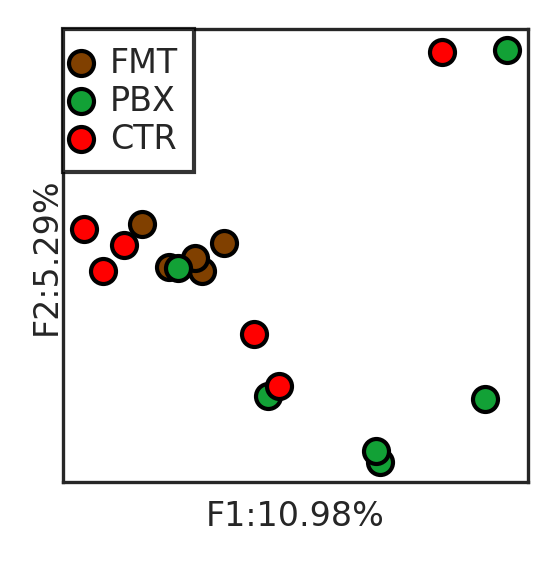

In [11]:
xi,yi = 0,1
xc,yc = df_tca.columns[xi], df_tca.columns[yi]
fig = plt.figure(figsize = [2,2], dpi = 300)
ax = fig.add_subplot(111)

for g, mdf in meta_abx_mwt.groupby(['Group']):
    subjects = mdf['Participant']#.astype(str)
    gl, gc = rename_groups(g)
    ax.scatter(df_tca.loc[subjects, xc],df_tca.loc[subjects, yc],label = gl, c = gc, edgecolors='k')

ax.set_xlabel(xc)
ax.set_ylabel(yc, labelpad=0)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(frameon=True, handlelength = .1, fontsize = SMALL_SIZE, labelspacing=.15,borderpad=.5, borderaxespad=.0, loc='upper left',edgecolor='k', fancybox=False)
plt.show()



apply permanova to a selected number of dimension in the reduced space.
Here, we take the minimal number of factores such that the commulative explained variance by these factors is greater than 25%

In [12]:
meta_perm = meta_abx_mwt.copy()
meta_perm['rGroup'] = meta_perm['Group']
meta_perm['Phase'] = ""
meta_perm['SampleID'] = meta_perm['Participant']

perm_res = pd.DataFrame(columns=['g1','g2','p'])

n_factors = (np.cumsum(tcam.explained_variance_ratio_) < .25).sum() + 1 # 25% variance

table = (df_tca * tcam._sorted_singular_vals[:-1]).copy()

for g1,g2, in combinations(meta_perm['rGroup'].unique(),2):
    meta_comp = meta_perm.loc[meta_perm['rGroup'].isin([g1,g2])].copy()
    
    table_comp = df_tca.loc[meta_comp['SampleID']].copy()
    
    n_all = meta_perm.loc[meta_perm['rGroup'].isin([g1,g2])].shape[0]
    n_1 = meta_perm.loc[meta_perm['rGroup'].isin([g1])].shape[0]
    n_2 = meta_perm.loc[meta_perm['rGroup'].isin([g2])].shape[0]
    n_perm = int(np.math.factorial(n_all) / (np.math.factorial(n_1 )*  np.math.factorial(n_2)) )
    p = run_permanova(meta_comp, df_tca.iloc[:,:n_factors].copy(), nperms = n_perm)
    perm_res.loc[perm_res.shape[0],:] = [g1,g2,p]
    
perm_res

,g1,g2,p
0,aFMT,probiotics,0.0454545
1,aFMT,spontaneous,0.969697
2,probiotics,spontaneous,0.123377


Barplot for $F_1$'s "feature loadings"

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


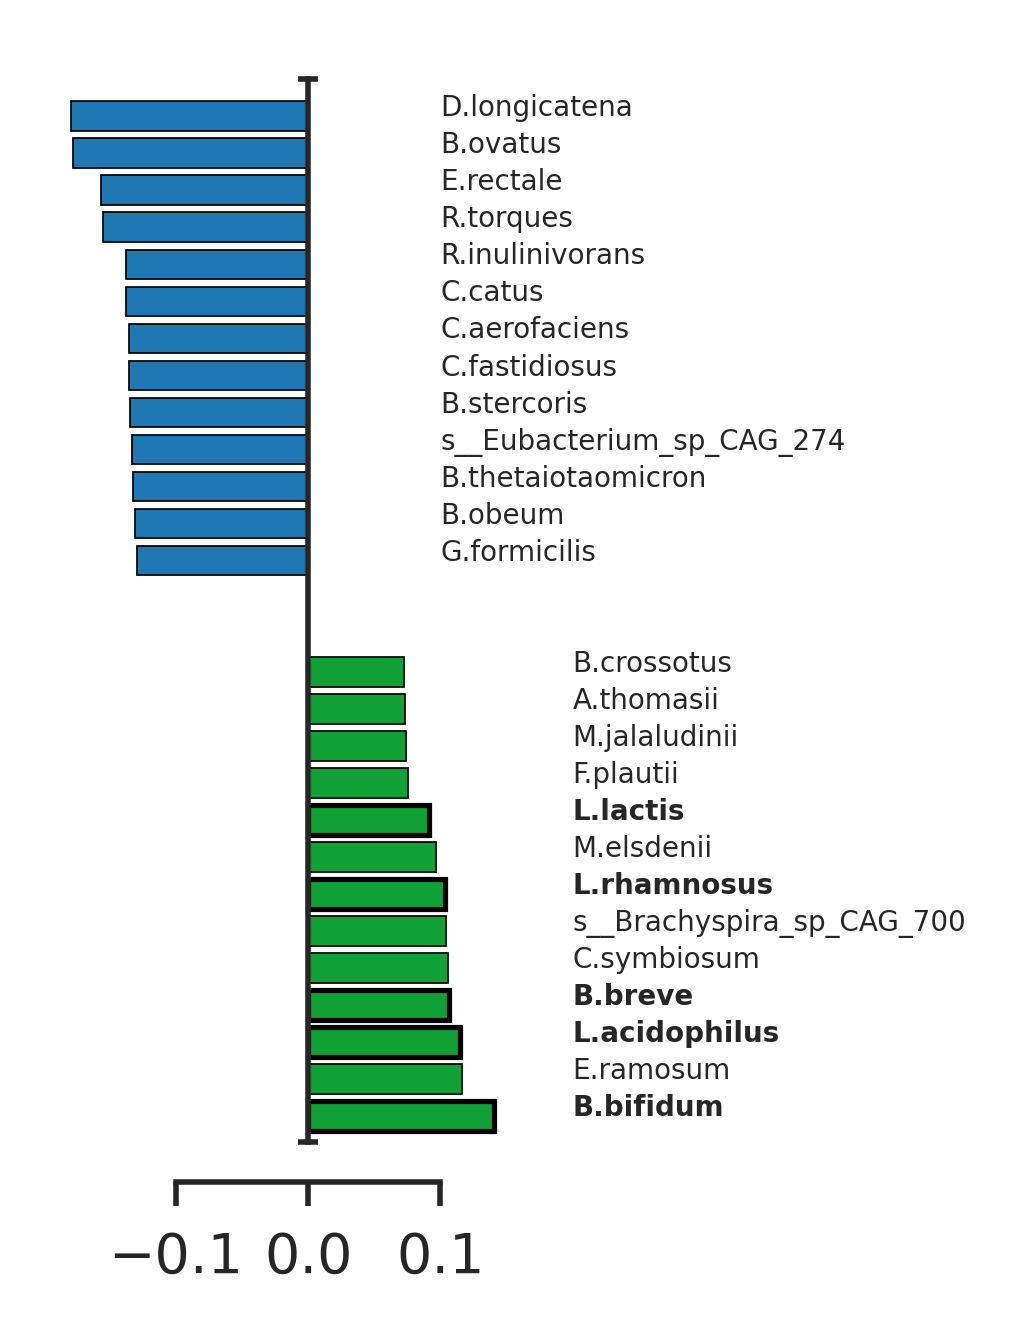

In [14]:
loadings_f1 = df_loadings.iloc[:,0].copy().sort_values(ascending=False).copy()

loadings_f1 = loadings_f1[(loadings_f1 > loadings_f1.quantile(.975)) | (loadings_f1 < loadings_f1.quantile(.025)) ]
loadings_f1 = loadings_f1.rename('F1')
loadings_f1 = loadings_f1.reset_index()

species_list = ['s__Bifidobacterium_bifidum',
 's__Lactobacillus_acidophilus',
 's__Bifidobacterium_breve',
 's__Lactobacillus_rhamnosus',
 's__Lactococcus_lactis']

names_lst = ['B.bifidum',
  'L.acidophilus',
  'B.breve',
  'L.rhamnosus',
  'L.lactis']


group_colors = {
    'CTR': 'r',
    'FMT': '#804000',
    'PBX': '#12a136'
}
fig,ax  = plt.subplots(1,1, figsize=[1.2,3], dpi = 500)
ax.barh(y = loadings_f1.query('F1 > 0').index, width = loadings_f1.query('F1 > 0')['F1'], color = group_colors['PBX']
       , linewidth = .25, edgecolor = 'k')
ax.barh(y = loadings_f1.loc[loadings_f1['index'].isin(species_list)].index
        , width = loadings_f1.loc[loadings_f1['index'].isin(species_list),'F1']
        , color = group_colors['PBX'], linewidth = .75, edgecolor = 'k')
ax.barh(y = loadings_f1.query('F1 < 0').index.astype(int) + 2, width = loadings_f1.query('F1 < 0')['F1']
        , linewidth = .25, edgecolor = 'k')


ax.set_yticks([-.7,loadings_f1.index.max() + 3])
ax.set_yticklabels([])

for i, row in loadings_f1.query('F1 > 0').iterrows():
#     if row['index'] in species_list:
    sname = str(row['index'])
    try:
        sg, ssp = sname.replace("s__","").replace("_"," ").split(" ")
        sname = f"{sg[0]}.{ssp}"
        
    except ValueError as ve:
        sname = str(row['index'])
        
    if sname in names_lst:
        ax.text(x=.2, y=i, s = sname, fontdict={'size':4, 'weight':'bold'})
    else:
        ax.text(x=.2, y=i, s = sname, fontdict={'size':4})

    
for i, row in loadings_f1.query('F1 < 0').iterrows():
    sname = str(row['index'])
    try:
        sg, ssp = sname.replace("s__","").replace("_"," ").split(" ")
        sname = f"{sg[0]}.{ssp}"
    except ValueError as ve:
        sname = str(row['index'])
        
    if sname in names_lst:
        ax.text(x=.1, y=i+2, s = sname, fontdict={'size':4, 'weight':'bold'})
    else:
        ax.text(x=.1, y=i+2, s = sname, fontdict={'size':4})
                
    

ax.yaxis.set_tick_params(size = 3, length = 400,direction = 'inout')
ax.tick_params()

sns.despine( top=True,right=True,trim=True)

ax.spines['left'].set_position('zero')
ax.set_xlabel("")
plt.show()


### Prune features for lmer 

Venn diagram and bar graphs. Bar levels are per-subject AUC for all significant bacteria according to the workflows. The top Venn diagram relates each bacterium to the workflow it was detected in (left - standard, right - tcam pruning, middle - intersection of both strategies output). Bars represent medians and errors are top and bottom quartiles of the data.

In [15]:
def prune_factors(transformed_data, row_factors, mwt_transformer, criterion = 'n_factors', threshold = -1 ):

    assert criterion in ['n_factors', 'min_total_var','min_var','gap']
    
    
    mwt_aov = transformed_data.copy()

    mwt_aov.columns = np.arange(0,mwt_aov.columns.size)

    def apply_f(x):
        return pd.Series(scipy.stats.f_oneway(*[x.loc[v] for k,v in row_factors.items()])
                         , index = ['F', 'P(>F)'])
    
    if criterion == 'min_total_var':
        n_factors = np.argmax(mwt_transformer.explained_variance_ratio_.cumsum() > threshold) + 1
    elif criterion == 'min_var':
        n_factors = np.argmin(mwt_transformer.explained_variance_ratio_ > threshold)
    elif criterion == 'gap':
        n_factors = np.argmin((-np.diff(mwt_transformer.explained_variance_ratio_)) > threshold)
    else:
        n_factors = mwt_transformer.explained_variance_ratio_.size if threshold == -1 else threshold
    
    n_factors = max(n_factors, 1)

    fres = (mwt_aov.iloc[:,:n_factors]).apply(apply_f).T.sort_values('P(>F)')
    
    fres['q'] = multipletests(fres['P(>F)'].values, method = 'fdr_bh')[1]
    display(fres)
    return fres.sort_values('q')

def rename_bugs(bug):
    bugtitle = bug.replace('s__','')
    bugtitle = f'{bugtitle[0]}.{bugtitle.split("_",1)[-1]}'
    if 'sp_' in bugtitle:
        bugtitle = bugtitle.replace('sp_','sp.')
    if 'CAG_' in bugtitle:
        bugtitle = bugtitle.replace('CAG_','CAG')
    bugtitle = bugtitle.replace("_"," ")
    return bugtitle







In [16]:
# construct a row mapping dictionary, relating each rowname (index) in the data to the relevant factor (group)
rmapping_ = meta_abx_mwt.groupby('Group').apply(lambda x:x['Participant'].tolist()).to_dict()

# prune the factors according to their ability to seperate the data
fres = prune_factors(df_tca, rmapping_, tcam, criterion='min_total_var', threshold=.5)
fres = fres.loc[fres['P(>F)'] < 0.05].index.tolist() # take features with P < 0.05

# Compute the norm for each feature with respect to the chosen (significant) factors
absval = df_loadings.iloc[:,fres].copy()

# display(absval)
absval = absval.apply(np.linalg.norm, axis=1)**2

# log transform the squared norm
log_absval = np.log(absval)

# Fit a Laplace random variable based on the mean and sd/2 on the log(norm^2)
mean_logval = log_absval.mean()
sd_logval = log_absval.std()
random_var = scipy.stats.laplace(loc = mean_logval, scale=(sd_logval)/2)

# Monte Carlo estimation of the .75 quantile of the Laplace random variable 
rsample = pd.Series(random_var.rvs(10000)) # Sufficient sample
top_quar = rsample.quantile(0.95) # upper quartile estimation

ind_pruned = pd.Series(dtype=np.float64)

for ff in sorted(fres):
    ind_pruned_ = df_loadings.iloc[:,0].copy()
    ind_pruned_ = ind_pruned_[(ind_pruned_ > ind_pruned_.quantile(.85)) | (ind_pruned_ < ind_pruned_.quantile(.15)) ]    
    ind_pruned_ = ind_pruned_.loc[~ind_pruned_.index.isin(ind_pruned.index)]   
    ind_pruned = pd.concat([ind_pruned,ind_pruned_], axis=0)
display(ind_pruned)

ind_pruned = ind_pruned.index.to_series().reset_index(drop=True)
    
ind_pruned.to_csv("./tcam_post_abx_features_Sue2018.csv", index = False) # store the list of features


,F,P(>F),q
6,4.441026,0.032095,0.245735
0,4.176467,0.037805,0.245735
4,1.954286,0.178431,0.733116
7,1.659350,0.225574,0.733116
1,1.032115,0.381836,0.761139
3,1.014596,0.387717,0.761139
9,0.951302,0.409844,0.761139
8,0.704029,0.511283,0.830834
12,0.404282,0.675003,0.849135
11,0.330485,0.724031,0.849135


s__Asaccharobacter_celatus         -0.069932
s__Megasphaera_elsdenii             0.096396
s__Streptococcus_agalactiae         0.038866
s__Peptostreptococcus_anaerobius    0.058251
s__Brachyspira_sp_CAG_700           0.103925
                                      ...   
s__Parabacteroides_merdae          -0.094750
s__Clostridium_leptum              -0.058971
s__Peptostreptococcus_sp_MV1        0.046614
s__Anaerostipes_caccae              0.059192
s__Enterococcus_faecium             0.053236
Length: 146, dtype: float64

Next, we use an `R` script to run `lmer` per taxa.
Then, we do the correction for multiple tests using only the above list of taxa found as major contibutors to factors whose scores significantly differ between groups (ANOVA)

The r script is stored at ./Suez2018_prunnin.R

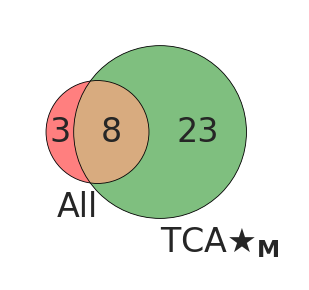

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


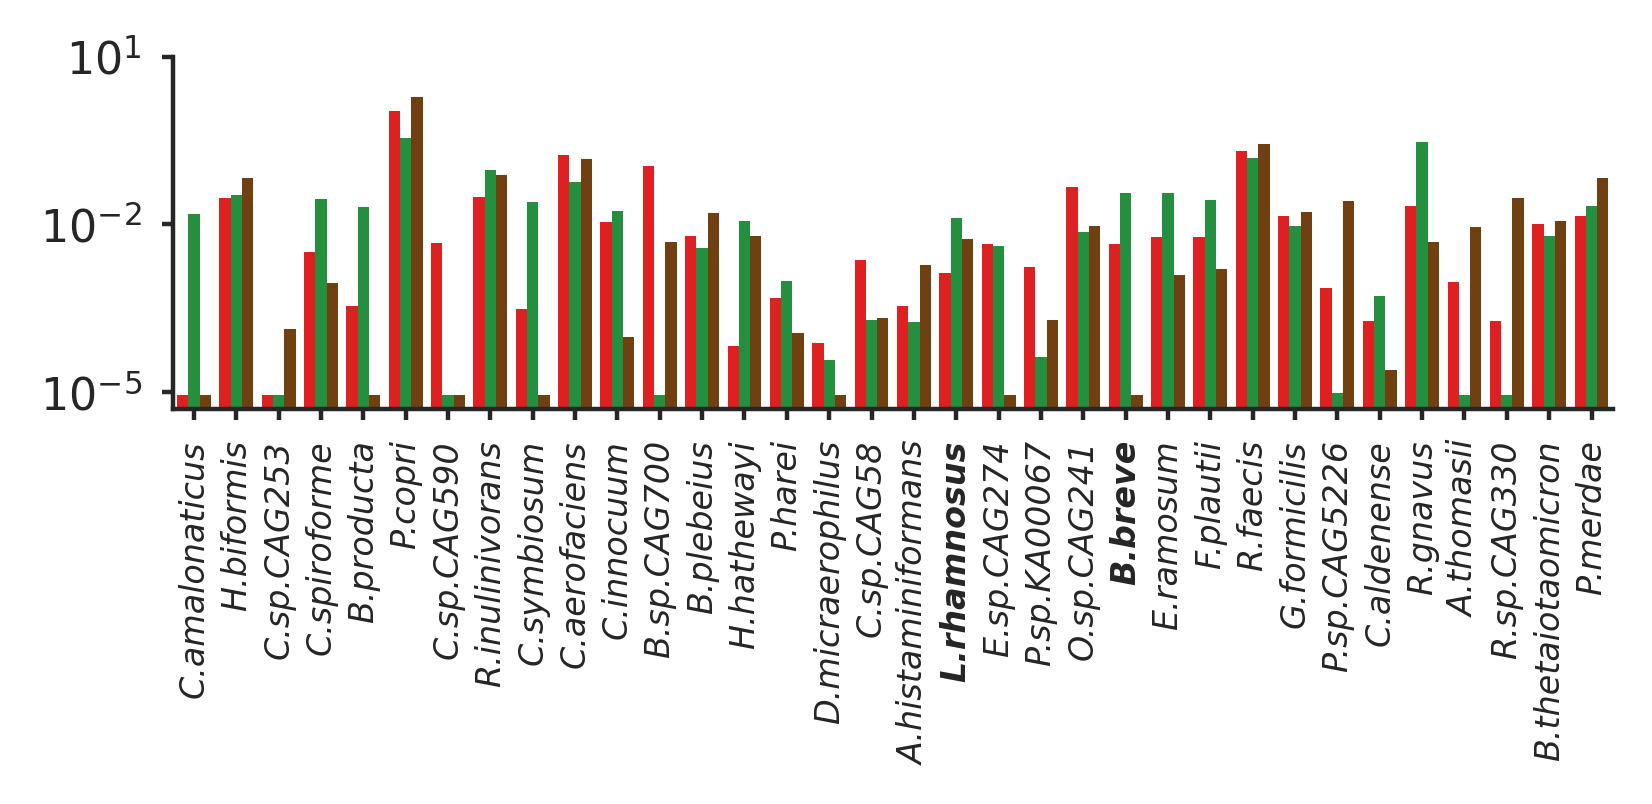

In [17]:
pruned_lmer_res = pd.read_csv("./Suez2018_pruned_ra_lmer_results.txt", sep = "\t", index_col=0)
pruned_lmer_res = pruned_lmer_res.loc[pruned_lmer_res['interaction.padj'] < 0.05]
lmer_res = pd.read_csv("./Suez2018_ra_lmer_results.txt", sep = "\t", index_col=0)
lmer_res = lmer_res.loc[lmer_res['interaction.padj'] < 0.05]

fig = plt.figure(figsize=[1,1], dpi = 300)
ax = fig.add_subplot(111)
v = venn2(subsets = [set(lmer_res.index),set(pruned_lmer_res.index) ] , set_labels = ('A', 'B')
          , ax = ax, alpha = .5)
venn2_circles(subsets = [set(lmer_res.index),set(pruned_lmer_res.index) ], linewidth=.2)
v.get_label_by_id('A').set_text('All')
v.get_label_by_id('A').set_fontsize(8)
v.get_label_by_id('B').set_text('TCA$\\bigstar_{\\bf{M}}$')
v.get_label_by_id('B').set_fontsize(8)

plt.show()


sig_features_tca = pruned_lmer_res.index.to_series().reset_index(drop=True).rename('Feature').to_frame()
sig_features_tca['TCA'] = True

sig_features_all = lmer_res.index.to_series().reset_index(drop=True).rename('Feature').to_frame()
sig_features_all['ALL'] = True

sig_features_list = sig_features_tca.merge(sig_features_all, on = 'Feature', how = 'outer').fillna(False).sort_values(['ALL','TCA'],ascending=[False,True])


rawdata_plot = pd.read_csv("./Suez2018.txt", sep = "\t", index_col=list(range(6)))

bar_rawdata_plot = rawdata_plot.groupby(level=['Participant','rGroup']).sum().loc[:,sig_features_list['Feature']]
bar_rawdata_plot = pd.melt(bar_rawdata_plot, ignore_index=False, var_name='Feature', value_name='RA').reset_index()
bar_rawdata_plot['Feature'] = bar_rawdata_plot['Feature'].apply(rename_bugs)



fig = plt.figure(figsize=[4,1], dpi = 400)
ax = fig.add_subplot(111)


bar_rawdata_plot_cap = bar_rawdata_plot.copy()
bar_rawdata_plot_cap.loc[bar_rawdata_plot_cap['RA'] < 5e-6, 'RA'] = 5e-6

sns.barplot(data = bar_rawdata_plot_cap , x = 'Feature', y = 'RA', ci=None, dodge=.001 , linewidth = 0
            , hue='rGroup', palette=group_colors, hue_order = ['CTR','PBX','FMT'] )
ax.legend_.set_visible(False)
ax.xaxis.set_tick_params(rotation = 90, labelsize = 6)

ax.set_yscale('log')
ax.set_yticks(np.logspace(-5,1, num = 3))
ax.set_yticks([],minor=True)
ax.set_ylim(5e-6,10)
ax.yaxis.set_tick_params(size = 2)
ax.xaxis.set_tick_params(size = 2)


ax.set_xlabel(None)
ax.set_ylabel(None)
sns.despine()
ax.set_clip_box(fig.bbox)
fig.subplots_adjust(left = 0, bottom=0)

for t in ax.get_xticklabels():
    t.set_fontstyle('italic')
    t.set_size(6)
    if t.get_text() in names_lst:
        t.set_fontweight('bold')

        
plt.show()

### Time series of bacterial abundance 

* Time series of relative abundance levels for features discovered only when pruning the features. 
* Time series of relative abundance levels for features discovered when no pruning scheme is used 
* and by both methods (with and without TCAM pruning) (bottom). 

### TCAM

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


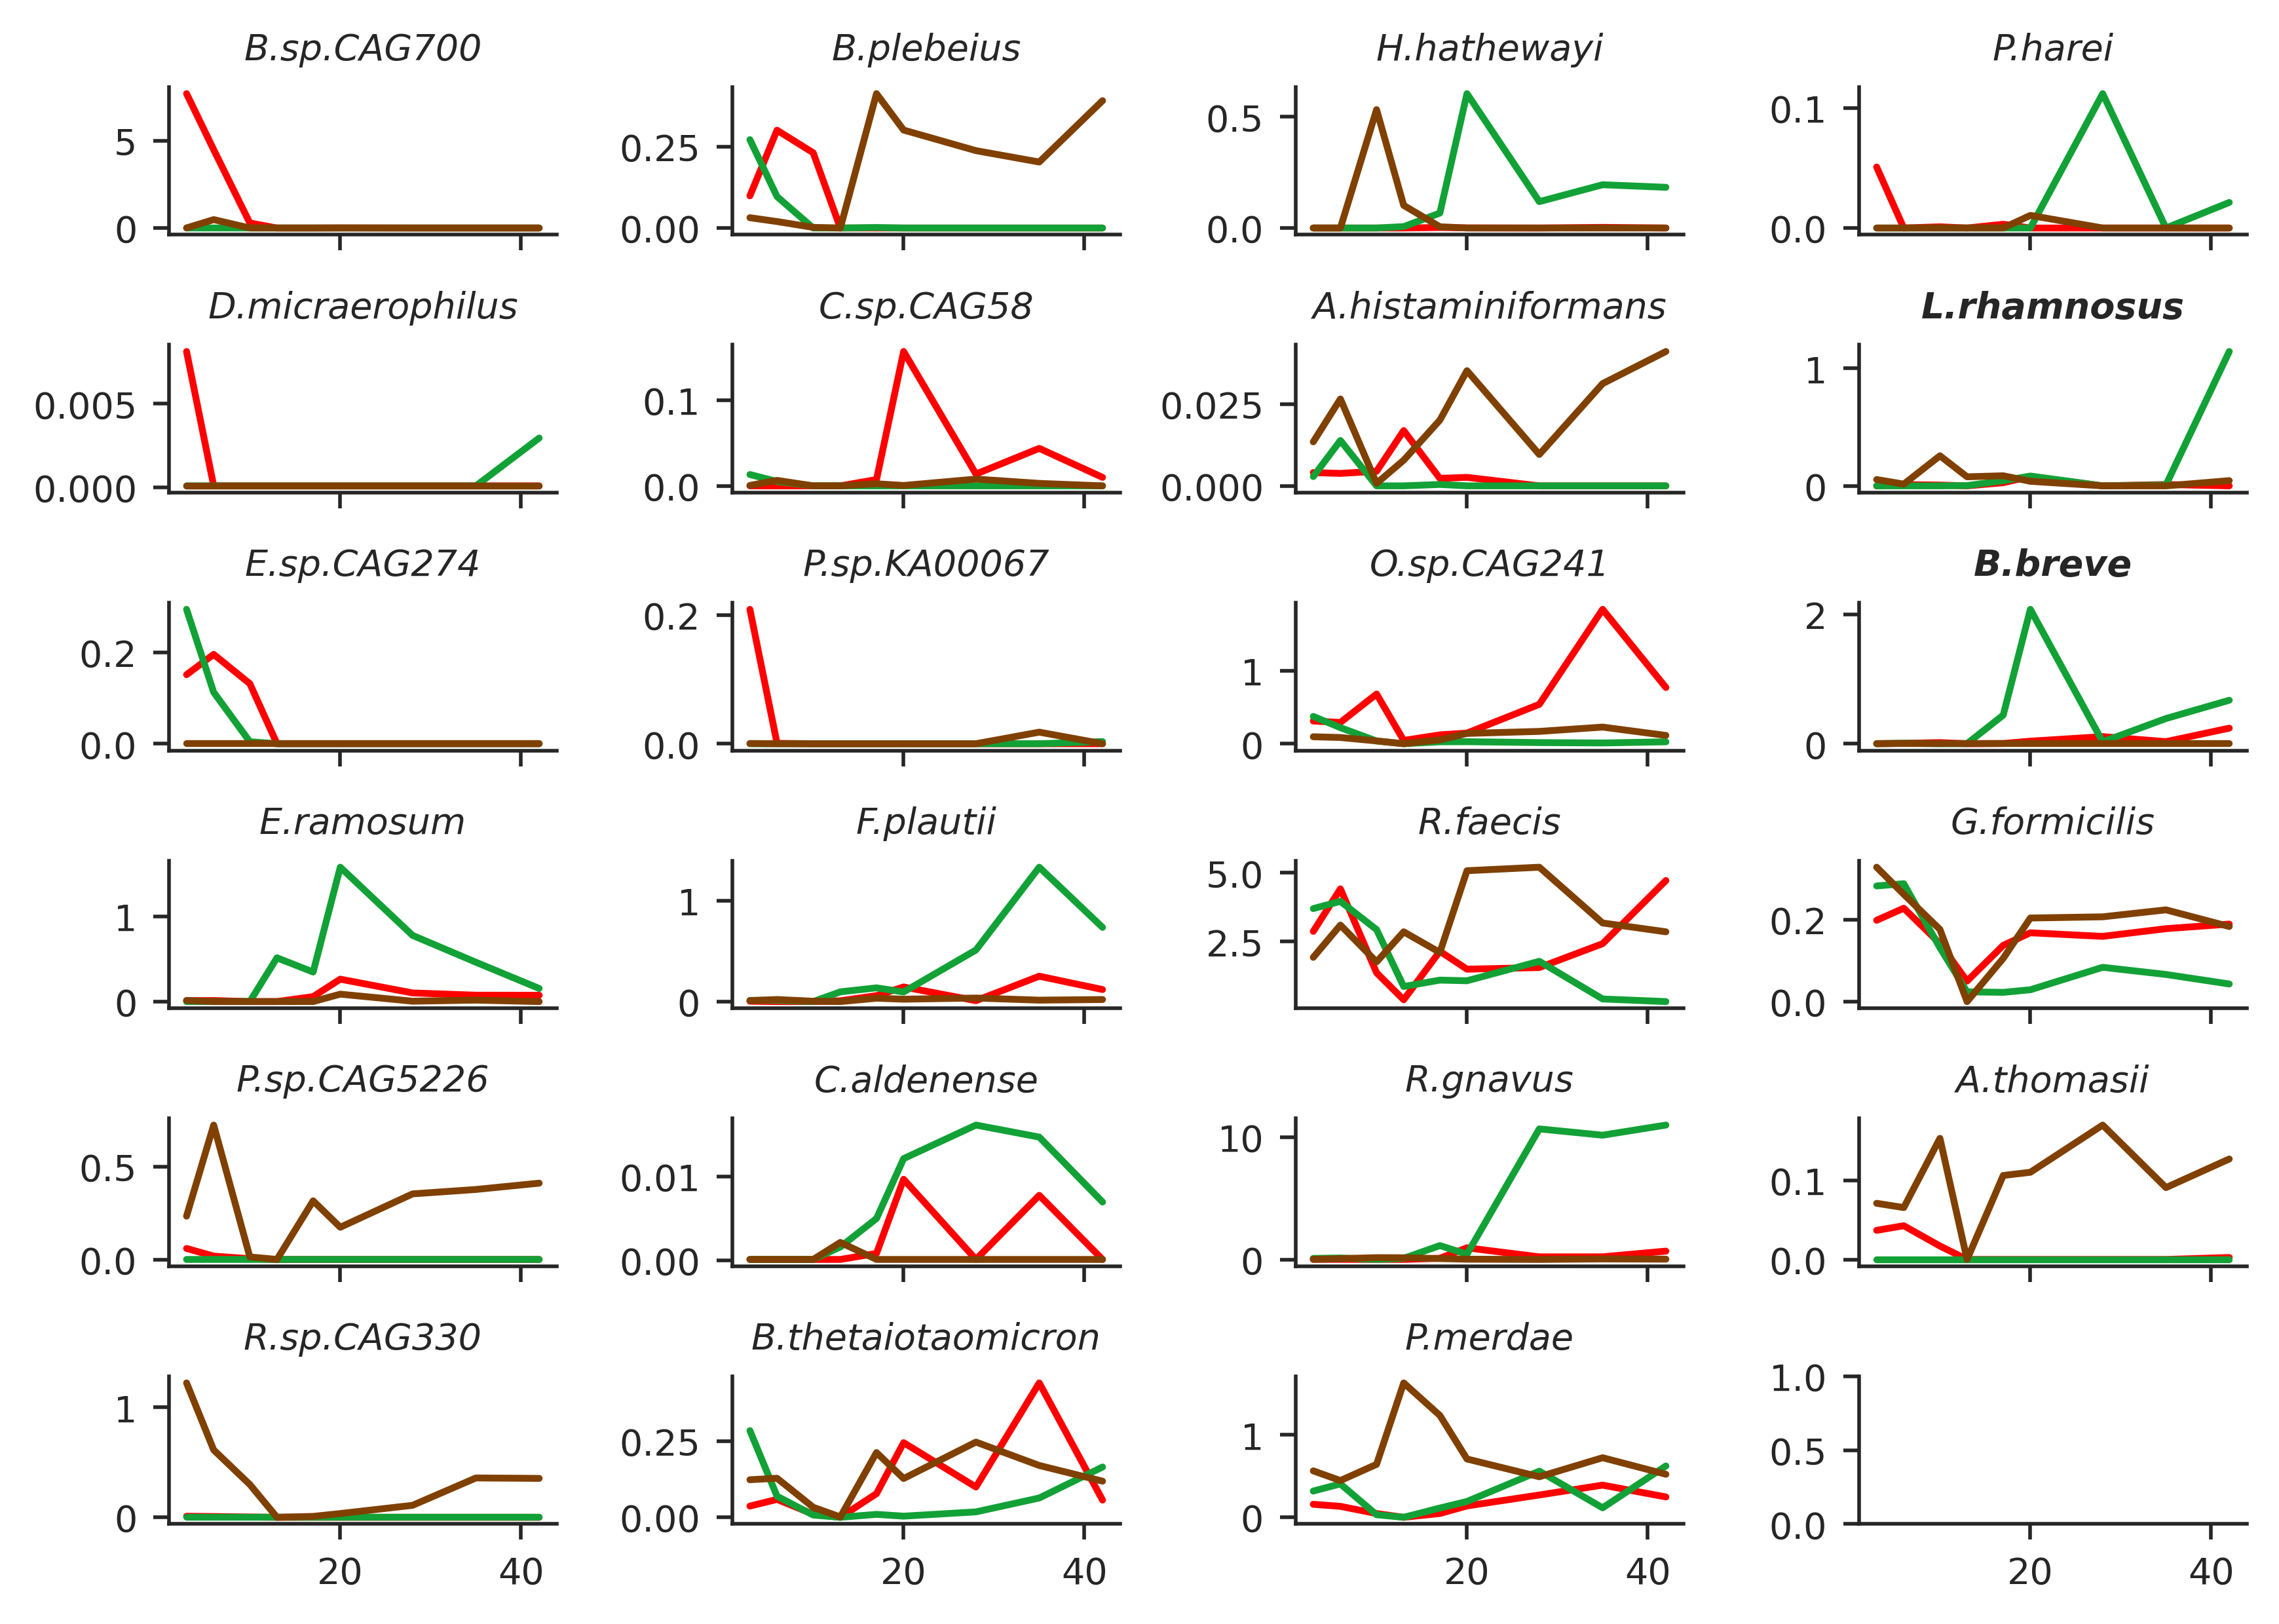

### No pruning

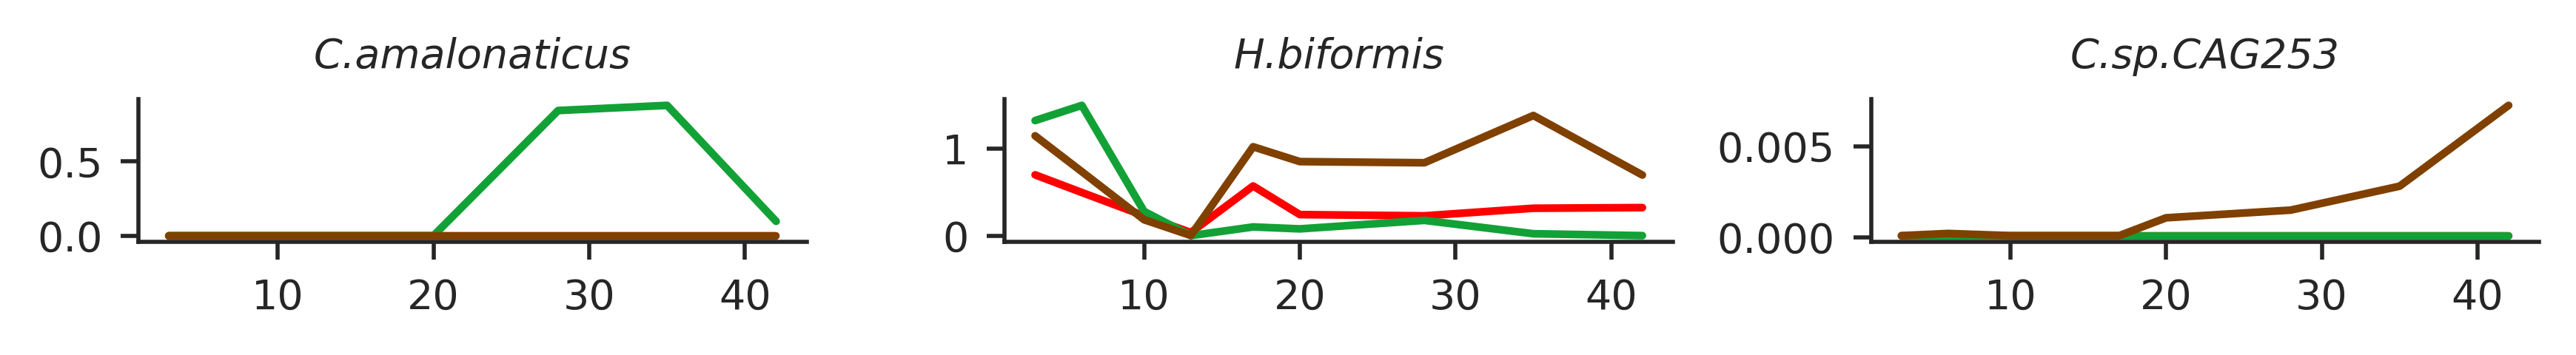

### Both

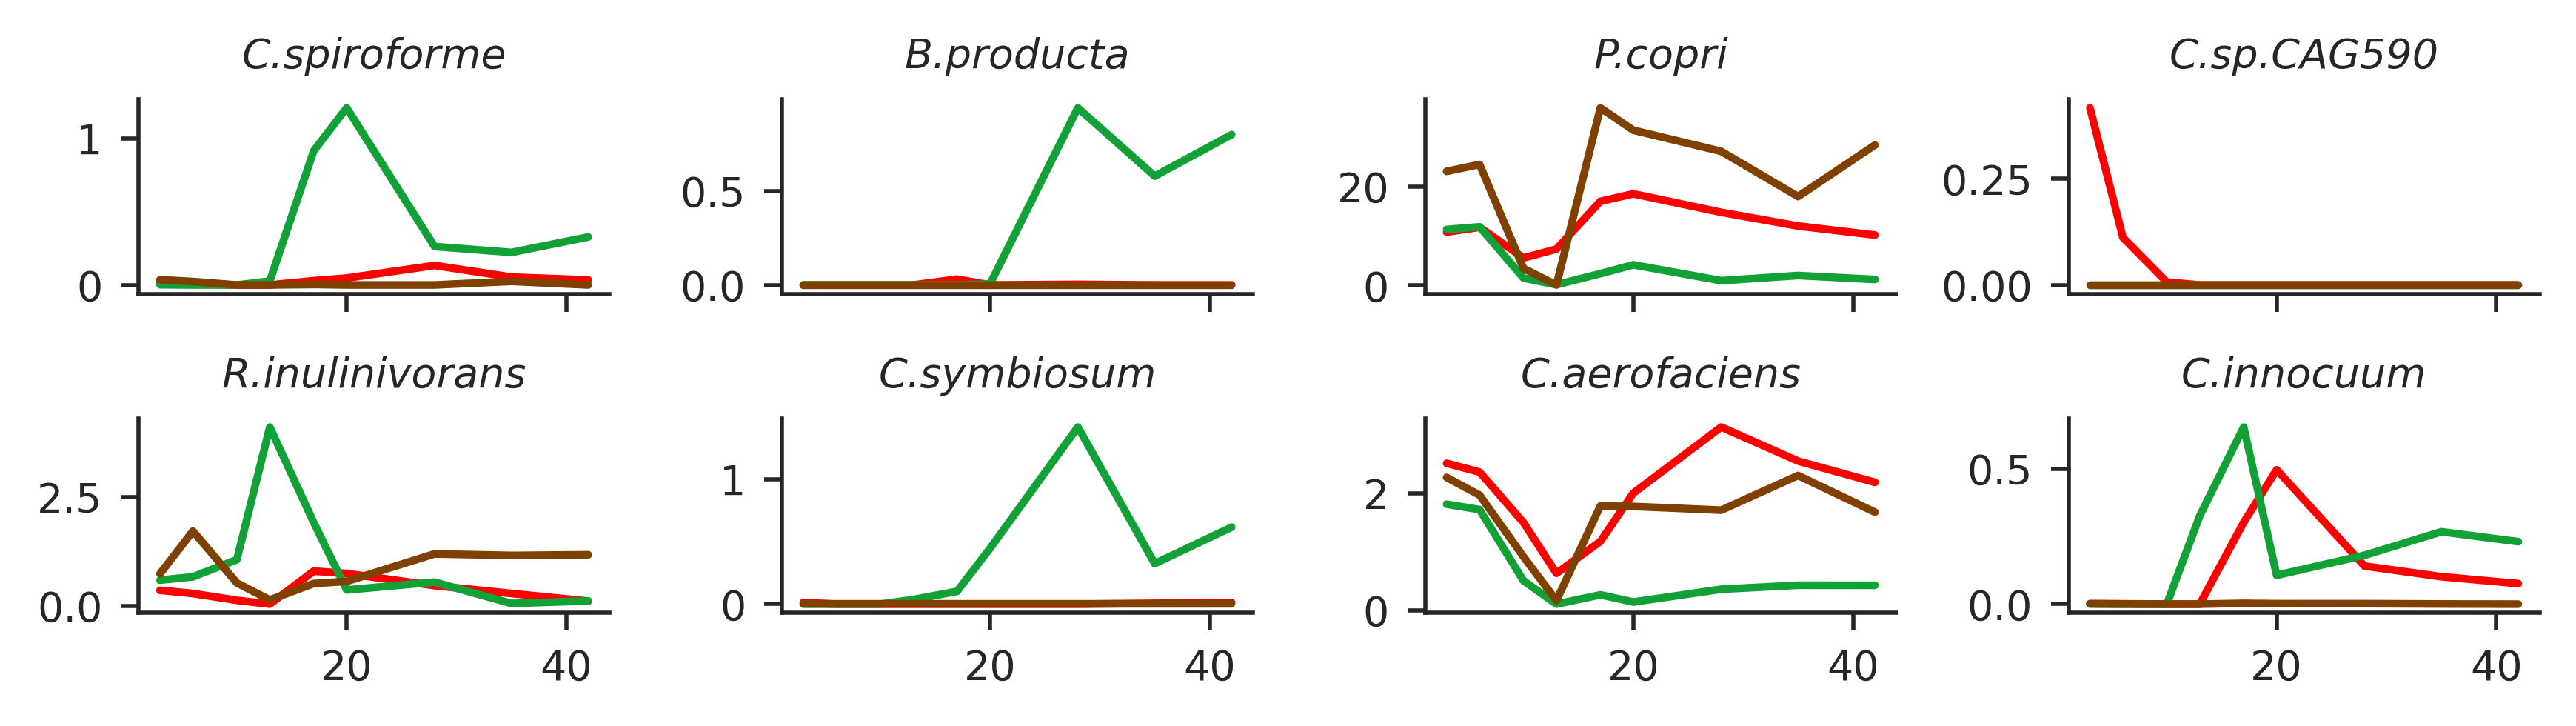

In [18]:

sig_features_listcp = sig_features_list.copy()
sig_features_listcp['fFeature'] = sig_features_listcp['Feature'].apply(rename_bugs)
sig_features_listcp['feature_group'] = 'Both'
sig_features_listcp.loc[~sig_features_listcp['TCA'], 'feature_group'] = 'ALL'
sig_features_listcp.loc[~sig_features_listcp['ALL'], 'feature_group'] = 'TCA'



data_renamed = rawdata_plot.rename(columns=rename_bugs)

sig_features_list_ts = sig_features_list.copy()
sig_features_list_ts['Feature'] = sig_features_list_ts['Feature'].apply(rename_bugs)

display_markdown("### TCAM", raw=True)

fig, axe = plt.subplots(6,4,sharex = True, figsize=[7,5], dpi = 500)
e=0

time_series_list = []
for i,f in enumerate(sig_features_list_ts.query("TCA and (not ALL)")['Feature']):
    e = i//4
    tsdata = (100*data_renamed[f]).copy().reset_index()
    time_series_list.append(tsdata.groupby(["Participant", "Group", "Day", "Phase", "rGroup", "rDay"])[[f]].mean().copy())
    sns.lineplot(data = tsdata, x='rDay', y = f, ci = None
                 , hue='rGroup', palette=group_colors, hue_order = ['CTR','PBX','FMT']
                 , ax = axe[e][i%4])
    axe[e][i%4].legend_.set_visible(False)
    axe[e][i%4].set_title(f, fontdict = {"fontstyle":"italic", "size": 8})
    if f in names_lst:
        axe[e][i%4].set_title(f,fontdict = {'fontweight':'bold',"fontstyle":"italic", "size": 8})
    axe[e][i%4].set_xlabel('')
    axe[e][i%4].set_ylabel('')

    
sns.despine()
plt.tight_layout()
plt.show()



time_series_list = []
display_markdown("### No pruning", raw=True)
fig, axe = plt.subplots(1,3,sharex = True,  figsize=[7,1], dpi = 500)

for e,f in enumerate(sig_features_list_ts.query("(not TCA  )and ALL")['Feature']):
    tsdata = (100*data_renamed[f]).copy().reset_index()
    tsappend = tsdata.copy()
    tsappend = tsappend.groupby(["Participant", "Group", "Day", "Phase", "rGroup", "rDay"])[[f]].mean().copy()
    time_series_list.append(tsappend)
    
    sns.lineplot(data = tsdata, x='rDay', y = f, ci = None
                 , hue='rGroup', palette=group_colors, hue_order = ['CTR','PBX','FMT']
                 , ax = axe[e])
    axe[e].legend_.set_visible(False)
    axe[e].set_title(f, fontdict = {"fontstyle":"italic", "size":8})
    axe[e].set_xlabel('')
    axe[e].set_ylabel('')
    
sns.despine()
plt.tight_layout()
plt.show()

time_series_list = []

display_markdown("### Both", raw=True)
fig, axe = plt.subplots(2,4, sharex = True, figsize=[7,2], dpi = 500)
e=0

for i,f in enumerate(sig_features_list_ts.query("TCA and ALL")['Feature']):
    if i > 3:
        e = 1
    tsdata = (100*data_renamed[f]).copy().reset_index()
    time_series_list.append(tsdata.groupby(["Participant", "Group", "Day", "Phase", "rGroup", "rDay"])[[f]].mean().copy())
    
    sns.lineplot(data = tsdata, x='rDay', y = f, ci = None
                 , hue='rGroup', palette=group_colors, hue_order = ['CTR','PBX','FMT']
                 , ax = axe[e][i%4])
    axe[e][i%4].legend_.set_visible(False)
    axe[e][i%4].set_title(f, fontdict = {"fontstyle":"italic", "size" : 8})
    if f in names_lst:
        axe[e][i%4].set_title(f,fontdict = {'fontweight':'bold',"fontstyle":"italic", "size" :8})
    axe[e][i%4].set_xlabel('')
    axe[e][i%4].set_ylabel('')

sns.despine()
plt.tight_layout()

plt.show()



# Principal Component Analysis

Reading the dataset

In [19]:
data_raw = pd.read_csv('./Suez2018.txt', sep = "\t", index_col = np.arange(6))
data_raw.rename(index={'Sp':'CTR','Prob':'PBX'}, level='rGroup', inplace=True)
data_raw.rename(index={'baseline':'BAS','intervention':'INT', 'antibiotics':'ABX'}, level='Phase', inplace=True)

display(data_raw.head())
display(data_raw.sum(axis=1).head())

,,,,,,s__Vagococcus_lutrae,s__Asaccharobacter_celatus,s__Megasphaera_elsdenii,s__Leuconostoc_carnosum,s__Streptococcus_agalactiae,s__Tyzzerella_nexilis,s__Akkermansia_muciniphila,s__Alistipes_timonensis,s__Peptostreptococcus_anaerobius,s__Streptococcus_anginosus_group,...,s__Clostridium_celatum,s__Fusobacterium_periodonticum,s__Acidaminococcus_intestini,s__Streptococcus_sobrinus,s__Anaerostipes_caccae,s__Enterococcus_faecium,s__Eubacterium_sp_CAG_180,s__Veillonella_dispar,s__Actinomyces_sp_S6_Spd3,s__Firmicutes_bacterium_CAG_238
Participant,Group,Day,Phase,rGroup,rDay,,,,,,,,,,,,,,,,,,,,,
602,aFMT,3.0,BAS,FMT,3.0,9.999999e-07,5.098103e-05,1.827615e-02,9.999999e-07,9.999999e-07,9.999999e-07,1.979763e-04,9.999999e-07,9.999999e-07,9.999999e-07,...,9.999999e-07,9.999999e-07,2.247164e-04,9.999999e-07,9.999999e-07,9.999999e-07,5.216708e-03,9.999999e-07,9.999999e-07,5.632903e-05
603,aFMT,3.0,BAS,FMT,3.0,9.999999e-07,4.783926e-04,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,2.903207e-02,9.999999e-07,9.999999e-07,9.999999e-07,...,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,5.647945e-05,9.999999e-07,9.999999e-07
605,aFMT,3.0,BAS,FMT,3.0,9.999998e-07,9.999998e-07,6.061606e-03,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,...,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07
606,aFMT,3.0,BAS,FMT,3.0,9.999999e-07,6.592127e-04,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,...,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07,9.999999e-07
701,probiotics,3.0,BAS,PBX,3.0,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,...,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,9.999998e-07,1.609697e-04,9.999998e-07,9.999998e-07


Participant  Group       Day  Phase  rGroup  rDay
602          aFMT        3.0  BAS    FMT     3.0     1.0
603          aFMT        3.0  BAS    FMT     3.0     1.0
605          aFMT        3.0  BAS    FMT     3.0     1.0
606          aFMT        3.0  BAS    FMT     3.0     1.0
701          probiotics  3.0  BAS    PBX     3.0     1.0
dtype: float64


## PCA of all timepoints


#### Colors per group

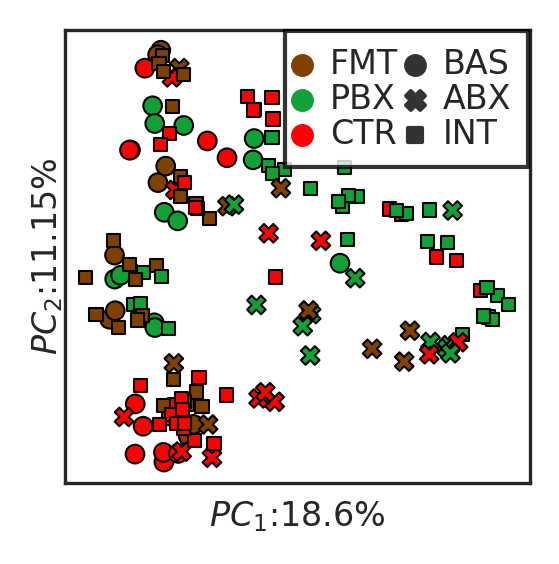

#### Colors per subject

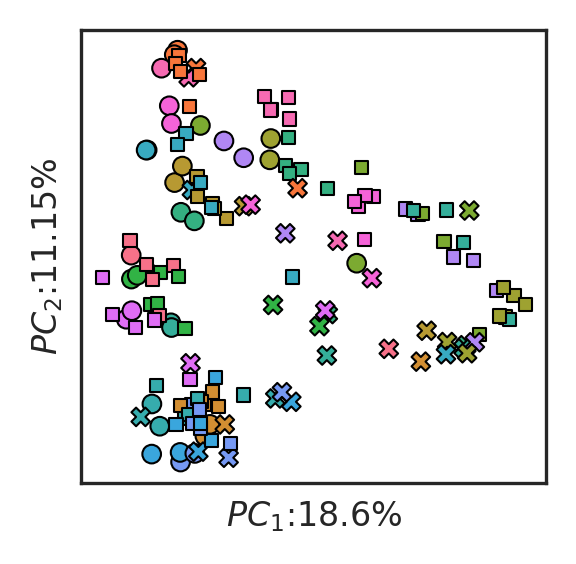

In [20]:
abx_log = data_raw.copy()
abx_log = np.log2(abx_log)
abx_log = abx_log - abx_log.mean()
pca = PCA()

abx_logpca = pca.fit_transform(abx_log)
abx_logpca = pd.DataFrame(abx_logpca, index = abx_log.index)
abx_logpca.columns = [f"$PC_{i}$:{np.round(100*v, decimals=2)}%" for i,v in enumerate(pca.explained_variance_ratio_, start=1)]

xiall,yiall = 0,1
xcall,ycall = abx_logpca.columns[xiall], abx_logpca.columns[yiall]


display_markdown("#### Colors per group", raw = True)
fig = plt.figure(figsize = [2,2], dpi = 300)
ax = fig.add_subplot(111)

plot_logpca = abx_logpca.reset_index()
hue_order = plot_logpca['rGroup'].unique()
hue_color = [group_colors[k] for k in hue_order]


splot = sns.scatterplot(data = plot_logpca , x=xcall, y=ycall, palette=hue_color, style='Phase', s=20
                , hue='rGroup', hue_order=hue_order, linewidth = .5, edgecolor='k'
                ,ax = ax )
ax.set_xticks([])
ax.set_yticks([])

hands, labs = splot.get_legend_handles_labels()
hands =  [x for i,x in enumerate(hands) if i%4 != 0]
labs = [x for i,x in enumerate(labs) if i%4 != 0]



ax.set_xlabel(xcall)
ax.set_ylabel(ycall, labelpad=0)

ax.legend(hands, labs, frameon=True, handlelength = .051, fontsize = SMALL_SIZE, labelspacing=.05,borderpad=.5, ncol=2, title=None
          , columnspacing=.5,markerscale=.75
          , borderaxespad=.051, loc='upper right',edgecolor='k', fancybox=False)


plt.show()

display_markdown("#### Colors per subject", raw = True)
plot_logpca['Participant'] = plot_logpca['Participant'].astype(str)
fig = plt.figure(figsize = [2,2], dpi = 300)
ax = fig.add_subplot(111)

splot = sns.scatterplot(data = plot_logpca , x=xcall, y=ycall, style='Phase', s=20
                , hue='Participant', linewidth = .5, edgecolor='k'
                ,ax = ax )
ax.set_xticks([])
ax.set_yticks([])
ax.legend_.set_visible(False)
plt.show()


## PCA plot of baseline samples

1-2 samples per each subjects. Points are colored according to participant

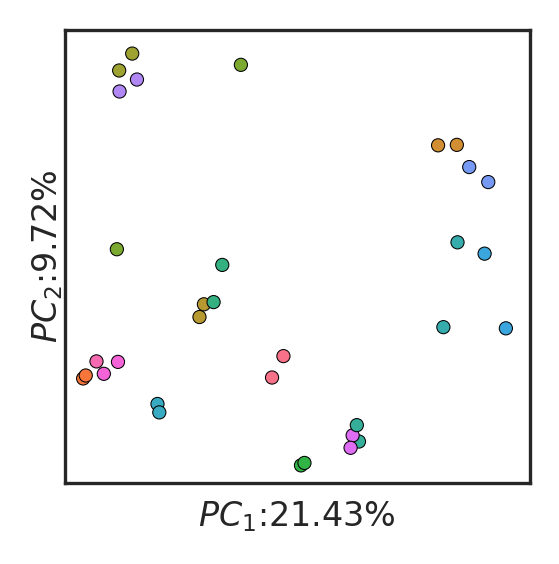

In [21]:
abx_log = data_raw.copy().query("Phase == 'BAS'")
abx_log = np.log2(abx_log)
abx_log = abx_log - abx_log.mean()
pca = PCA()

abx_logpca_bl = pca.fit_transform(abx_log)
abx_logpca_bl = pd.DataFrame(abx_logpca_bl, index = abx_log.index)
abx_logpca_bl.columns = [f"$PC_{i}$:{np.round(100*v, decimals=2)}%" for i,v in enumerate(pca.explained_variance_ratio_, start=1)]

xibl,yibl = 0,1
xcbl,ycbl = abx_logpca_bl.columns[xibl], abx_logpca_bl.columns[yibl]


fig = plt.figure(figsize = [2,2], dpi = 300)
ax = fig.add_subplot(111)

plot_logpca = abx_logpca_bl.reset_index()
hue_order = plot_logpca['rGroup'].unique()
hue_color = [group_colors[k] for k in hue_order]

ax.set_xlim(plot_logpca[xcbl].min()*1.1,plot_logpca[xcbl].max()*1.1)
ax.set_ylim(plot_logpca[ycbl].min()*1.1,plot_logpca[ycbl].max()*1.1)

plot_logpcacp = plot_logpca.copy()
plot_logpcacp['Participant'] = plot_logpcacp['Participant'].astype(str)
splot = sns.scatterplot(data = plot_logpcacp , x=xcbl, y=ycbl, style='Phase', s=10
                , hue='Participant', linewidth = .25, edgecolor='k'
                ,ax = ax )


ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel(xcbl)
ax.set_ylabel(ycbl, labelpad=0)


hands, labs = splot.get_legend_handles_labels()
hands =  [x for x in hands][-3:]
labs = [x for x in labs][-3:]
ax.legend_.set_visible(False)

plt.show()

## Correlation between truncated distances

Linear regression of average distance between subjects as reflected by first 2 PCs computed for all time points (x axis) and first 2 PCs computed only for the baseline phase.

Text(0, 0.5, 'between subjects\nat baseline')

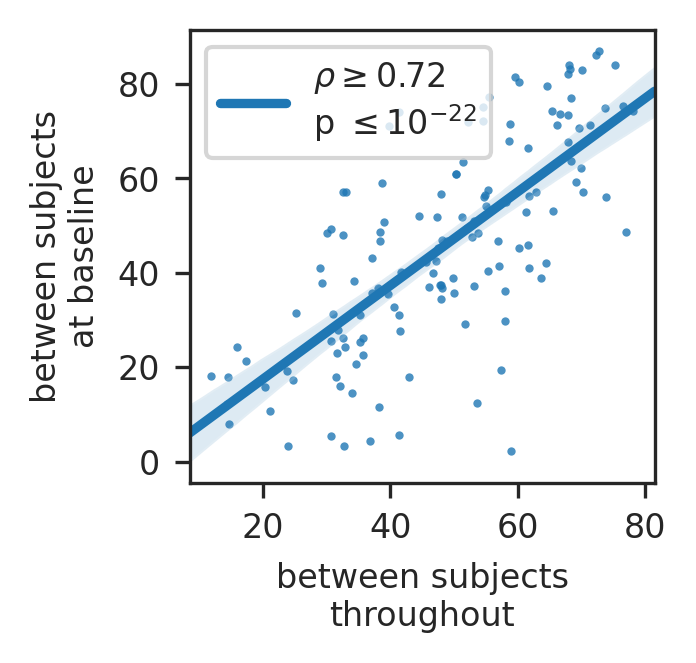

In [22]:

pca_bl_agg = abx_logpca_bl.groupby(level = ['Participant','rDay'])[[xcbl,ycbl]].mean()
new_index = pca_bl_agg.index.get_level_values('Participant').astype(str)
new_index = new_index + "_" + pca_bl_agg.index.get_level_values('rDay').astype(int).astype(str)
pca_bl_agg.index = new_index

pca_bl_dm = pairwise_distances(pca_bl_agg)
pca_bl_dm = pd.DataFrame(pca_bl_dm,index = pca_bl_agg.index, columns=pca_bl_agg.index)

for i in range(pca_bl_dm.shape[0]):
    for j in range(i, pca_bl_dm.shape[0]):
        pca_bl_dm.iloc[j,i] = None

        
pca_bl_dm = pd.melt(pca_bl_dm, var_name='sample2', ignore_index=False, value_name='dist').dropna()
pca_bl_dm = pca_bl_dm.reset_index().rename(columns = {'index':'sample1'})
pca_bl_dm['day1'] = pca_bl_dm['sample1'].apply(lambda x:x.split("_")[1])
pca_bl_dm['day2'] = pca_bl_dm['sample2'].apply(lambda x:x.split("_")[1])
pca_bl_dm['subject1'] = pca_bl_dm['sample1'].apply(lambda x:x.split("_")[0])
pca_bl_dm['subject2'] = pca_bl_dm['sample2'].apply(lambda x:x.split("_")[0])

pca_bl_dm = pca_bl_dm.query('subject1 != subject2')

pca_bl_dm = pca_bl_dm.groupby(['subject1','subject2'])['dist'].mean()



pca_agg = abx_logpca.groupby(level = ['Participant','rDay'])[[xcall,ycall]].mean()
new_index = pca_agg.index.get_level_values('Participant').astype(str)
new_index = new_index + "_" + pca_agg.index.get_level_values('rDay').astype(int).astype(str)
pca_agg.index = new_index

pca_dm = pairwise_distances(pca_agg)
pca_dm = pd.DataFrame(pca_dm,index = pca_agg.index, columns=pca_agg.index)

for i in range(pca_dm.shape[0]):
    for j in range(i, pca_dm.shape[0]):
        pca_dm.iloc[j,i] = None

pca_dm_frame = pca_dm.copy()
        
pca_dm = pd.melt(pca_dm, var_name='sample2', ignore_index=False, value_name='dist').dropna()
pca_dm = pca_dm.reset_index().rename(columns = {'index':'sample1'})
pca_dm['day1'] = pca_dm['sample1'].apply(lambda x:x.split("_")[1])
pca_dm['day2'] = pca_dm['sample2'].apply(lambda x:x.split("_")[1])
pca_dm['subject1'] = pca_dm['sample1'].apply(lambda x:x.split("_")[0])
pca_dm['subject2'] = pca_dm['sample2'].apply(lambda x:x.split("_")[0])

pca_dm = pca_dm.query('subject1 != subject2')

pca_dm = pca_dm.groupby(['subject1','subject2'])['dist'].mean()

fig = plt.figure(figsize = [2,2], dpi = 300)
ax = fig.add_subplot(111)

p_res = scipy.stats.pearsonr(pca_dm,pca_bl_dm)
rho = np.round(p_res[0],decimals=2)
rhop = str(np.ceil(np.log10(p_res[1])).astype(int))


sns.regplot(x=pca_dm,y=pca_bl_dm,truncate=False, ax = ax, scatter_kws={'s':4,'linewidth':0})
ax.legend(labels = [f'$\\rho \\geq${rho}\n'+'p $\leq 10^{'+str(rhop) + '}$'])

ax.set_xlabel("between subjects\nthroughout")
ax.set_ylabel("between subjects\nat baseline")





### PCA per phase, coloreed by group

* PCA plot of antibiotics phase. Points are colored according to group

* PCA plot of baseline phase. Points are colored according to group

* PCA plot of intervention phase. Points are colored according to group

### Antibiotics phase

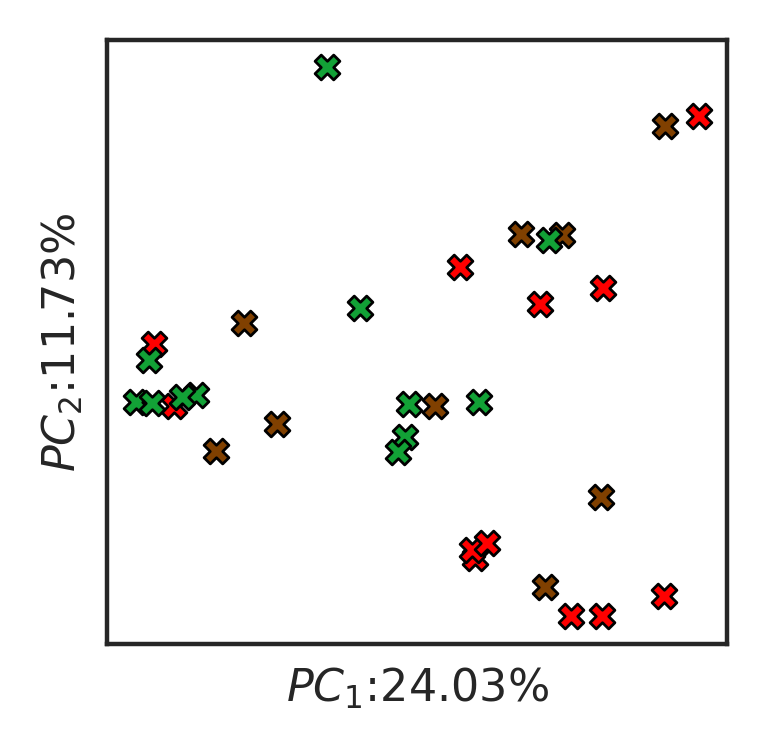

### Baseline phase

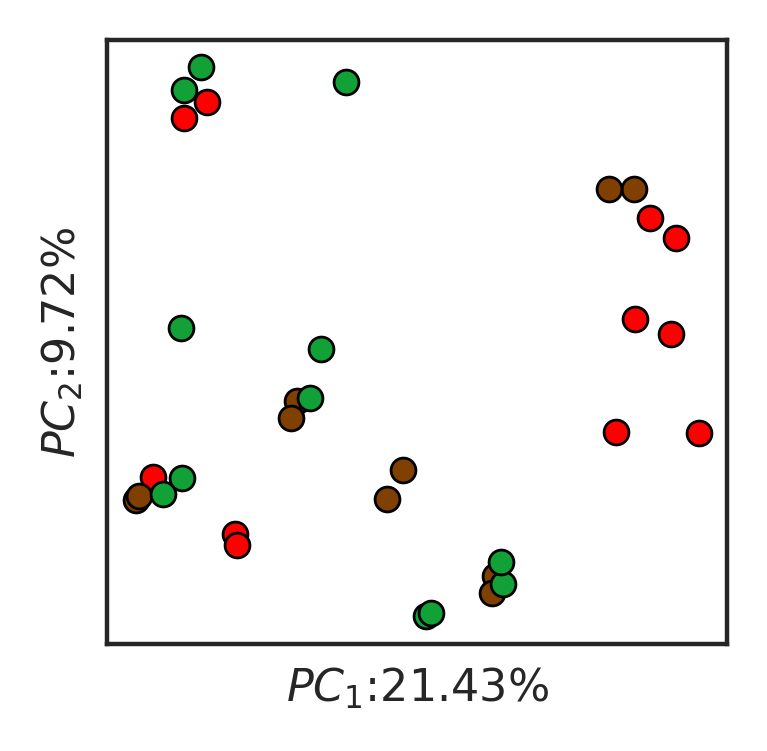

### Intervention phase

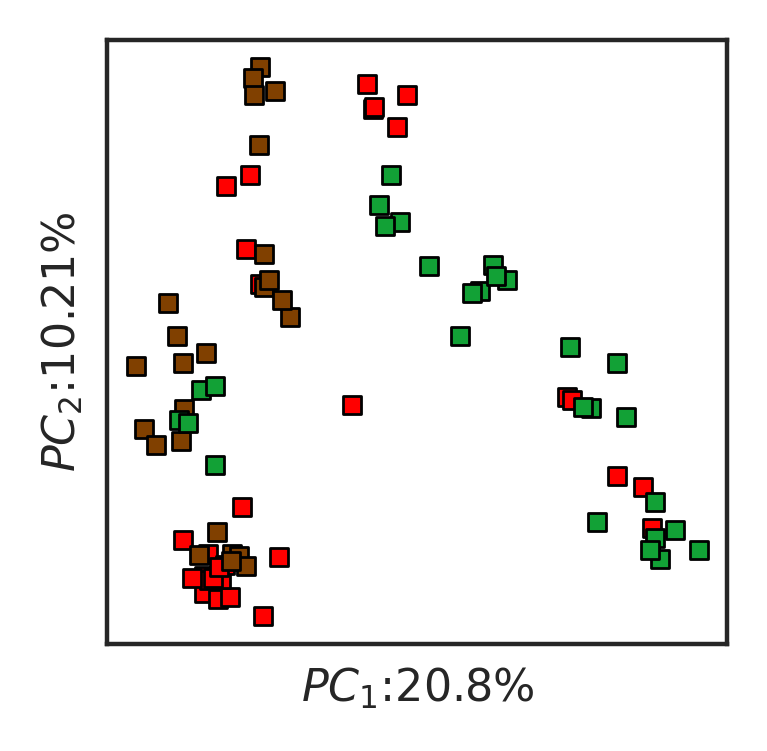

In [23]:
 from copy import deepcopy
from statsmodels.stats.multitest import multipletests

phase_names = {
    'ABX':'Antibiotics',
    'INT': 'Intervention',
    'BAS': 'Baseline'
}

plt.rcParams['axes.autolimit_mode'] = 'data' # 'round_numbers'

phase_markers = {'BAS':'o','ABX':'X', 'INT':'s'}

pca_dict = {}

for e,(ph, _abx_log) in enumerate(data_raw.groupby(level = 'Phase'), start = 1):
    display_markdown(f"### {phase_names[ph]} phase", raw = True)
    fig = plt.figure(figsize = [2,2], dpi = 400)
    ax = fig.add_subplot(111)
    abx_log = _abx_log.copy()
    abx_log = np.log2(100*abx_log)
    abx_log = abx_log - abx_log.mean()
    pca = PCA()

    abx_logpca = pca.fit_transform(abx_log)
    abx_logpca = pd.DataFrame(abx_logpca, index = abx_log.index)
    abx_logpca.columns = [f"$PC_{i}$:{np.round(100*v, decimals=2)}%" for i,v in enumerate(pca.explained_variance_ratio_, start=1)]

    pca_dict[ph] = {
        'PC': abx_logpca.copy(),
        'loadings': pd.DataFrame(pca.components_, index =  abx_logpca.columns, columns=abx_log.columns ),
        'expvar': pca.explained_variance_ratio_.copy(),
        'trans':deepcopy(pca)
    }
    
    
    xi,yi = 0,1
    xc,yc = abx_logpca.columns[xi], abx_logpca.columns[yi]
    
    

    for gr, df in abx_logpca.groupby(level='rGroup'):
        ax.scatter(df[xc],df[yc], c = group_colors[gr], label = gr, marker=phase_markers[ph], s=10 if ph == 'INT' else 20, linewidths=.5,edgecolors='k')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(yc)
    ax.set_xlabel(xc)    
    plt.show()

### PERMANOVA analysis

In [24]:
from itertools import combinations
from statsmodels.stats.multitest import multipletests

perm_phases = pd.DataFrame(columns=['Phase','comp','p'])

for ph in pca_dict.keys():
    table = pca_dict[ph]['PC'].copy()
    n_factors = get_truncated_factors(pca_dict[ph]['trans'], criterion = 'min_total_var', threshold = .2)
    for g1,g2, in combinations(table.index.get_level_values('rGroup').unique(),2):
        if f'{g1}-{g2}' not in perm_phases['comp']:
            g1,g2 = g2,g1

        table_comp = table.loc[table.index.get_level_values('rGroup').isin([g1,g2])].copy()
        meta_comp = table_comp.iloc[:,:0].copy()
        meta_comp['SampleID'] = meta_comp.index.tolist()
        meta_comp = meta_comp.reset_index()

        p = run_permanova(meta_comp, table_comp.iloc[:,:n_factors], nperms = 450)
        perm_phases.loc[perm_phases.shape[0],:] = [ph,f'{g1}-{g2}',p]

perm_phases['padj'] = multipletests(perm_phases['p'], method = 'fdr_bh')[1]
display(perm_phases)

,Phase,comp,p,padj
0,ABX,PBX-FMT,0.0666667,0.2
1,ABX,CTR-FMT,0.82,0.82
2,ABX,CTR-PBX,0.0177778,0.08
3,BAS,PBX-FMT,0.373333,0.528571
4,BAS,CTR-FMT,0.715556,0.805
5,BAS,CTR-PBX,0.213333,0.384
6,INT,PBX-FMT,0.0177778,0.08
7,INT,CTR-FMT,0.411111,0.528571
8,INT,CTR-PBX,0.135556,0.305


## References
<a id="1">[1]</a> 
Suez J. et al (2018). 
Post-Antibiotic Gut Mucosal Microbiome Reconstitution Is Impaired by Probiotics and Improved by Autologous FMT.
Cell, 174 (6)